# Shelved Modeling Experiments
The following are a few different roads that I started moving down and decided to put on pause to return another day.

(Note: This notebook is also a bit of a mess and I'm okay with that for now.)

## Imports

In [1]:
# Standard & quality of life imports
import pandas as pd   #loc[row_indexer,col_indexer]
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
from time import time
from datetime import datetime
%matplotlib inline

# Model prep & metric imports
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

# Regression model imports
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB

# Neural Network imports
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking, Embedding
from keras import backend

# Clustering imports
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from random import seed

# Data
df = pd.read_csv('./data/all_symptoms_cleaned.csv')

/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorF

Couldn't import dot_parser, loading of dot files will not be possible.


## Defining Functions

In [5]:
# For general ease.
def Reg_metrics(y_real, y_hat):
    print('RMSE            :',np.sqrt(metrics.mean_squared_error(y_real, y_hat)))   # Goal=0, Avg Distance
    print('Median Abs Error:',metrics.median_absolute_error(y_real,y_hat))          # Goal=0, Median Distance
    print('R Squared       :',metrics.r2_score(y_real, y_hat))          # Goal=1, Percent model can explain
    return

# Used in Neural Network
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

df_results = pd.DataFrame(columns=['model', 'features', 'parameters',
    'train_RMSE', 'train_Median_error', 'train_R_squared',
    'test_RMSE',  'test_Median_error',  'test_R_squared', 'time'])

# Everrything needed to run a standard regression model and have the results stored all in one function.\
# Disclaimer: Function is still effectively in beta.
def run_model(model, X, y, results_dataframe, save = True, 
              rando_state = 76, is_neural_network = False, 
              NN_epochs = 10, NN_batch_size = 32, NN_verbose = 0):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rando_state)

    if is_neural_network == False:
        # Performing normal running of model.
        model      = model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test  = model.predict(X_test)
        dict_model = {'model' : re.findall(r'^[^@]+\(', str(model))[0].strip("("),
                 'parameters' : model.get_params()}
        
    elif is_neural_network == True:
        # Running model for Neural Networks
        results = model.fit(X_train, y_train, 
                    epochs= NN_epochs, 
                    batch_size = NN_batch_size,
                    verbose = NN_verbose,
                    validation_data = (X_test,y_test))
        pred_train = model.predict(X_train)
        pred_test  = model.predict(X_test)
        dict_model = {'model' : "Neural Network",
                 'parameters' : {'layers' : [layer.get_config()['units'] for layer in results.model.layers],
                                 'batch_size' : NN_batch_size,
                                 'epochs'     : NN_epochs}}

    else:
        print("A non-boolian value was passed to is_neural_network.  This is an error.")
        return
    
    # Adding non-model dependant information to dict_model
    dict_model['time']               = datetime.fromtimestamp(time()).strftime('%m/%d/%Y, %H:%M:%S')
    dict_model['features']           = [feature for feature in X.columns]
    dict_model['train_RMSE']         = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    dict_model['train_Median_error'] = metrics.median_absolute_error(y_train, pred_train)
    dict_model['train_R_squared']    = metrics.r2_score(y_train, pred_train)
    dict_model['test_RMSE']          = np.sqrt(metrics.mean_squared_error(y_test, pred_test))
    dict_model['test_Median_error']  = metrics.median_absolute_error(y_test, pred_test)
    dict_model['test_R_squared']     = metrics.r2_score(y_test, pred_test)
    
    # Printing current results
    print(dict_model['model'] + ' Train')
    print('RMSE             : ' + str(dict_model['train_RMSE']))
    print('Median Abs Error : ' + str(dict_model['train_Median_error']))
    print('R Squared        : ' + str(dict_model['train_R_squared']))
    print('\n' + dict_model['model'] + ' Test')
    print('RMSE             : ' + str(dict_model['test_RMSE']))
    print('Median Abs Error : ' + str(dict_model['test_Median_error']))
    print('R Squared        : ' + str(dict_model['test_R_squared']))
    
    # Saving current results
    results_dataframe = results_dataframe.append(dict_model, ignore_index=True)
    if save == True:
        results_dataframe.to_csv('./data/modeling_results_' + datetime.fromtimestamp(time()).strftime('%m_%d_%Y')
                          , index = False)
    
    return results_dataframe

In [125]:
X = df[['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'concentrate', 'smoke', 'vape', 'symptom_a', 'symptom_d']]
y = df['after']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.25, random_state=42)

## Cannabis Clustering
Attempting Clustering for the amount of Cannabis Injested during a session and/or clustering the products thc & cbd percentages.  
There seems to be a few clusters when viewing the scatter plot of thc and cbd percentages.  I'm curious if these clusters might shed a light on other potential information.

In [25]:
df_dbs_results = pd.DataFrame(columns=['eps', 'min_samples', 'silhouette'])

DBS 0.6686208678882408


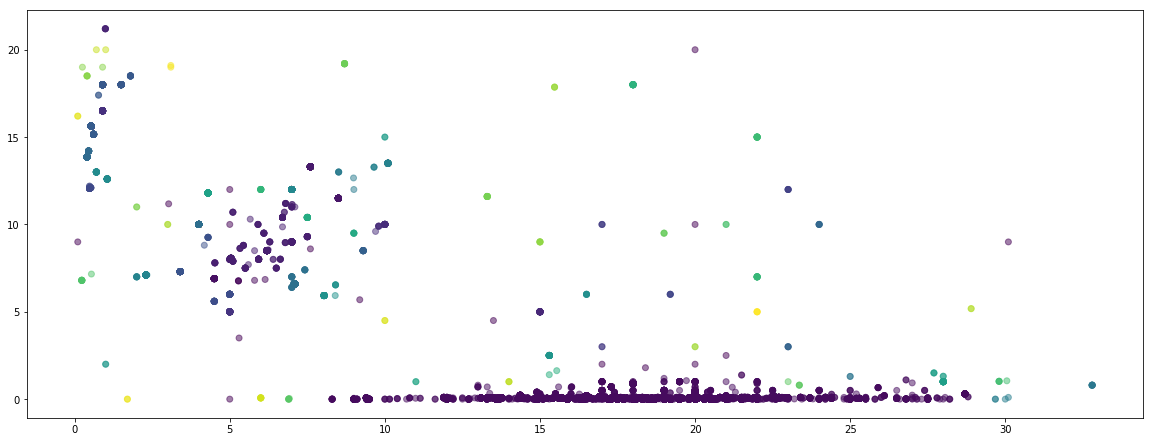

In [26]:
seed(76)
mask = (df['thc_%'] < 35) & (df['cbd_%'] < 25)
X_cluster = df[mask][['thc_%', 'cbd_%']]
df_cluster= X_cluster

model_DBS = DBSCAN(0.7, 2).fit(X_cluster)
df_cluster['y_DBS'] = model_DBS.fit_predict(X_cluster)
score_sil = silhouette_score(df_cluster,model_DBS.labels_)
print('DBS', score_sil)
plt.figure(figsize = (20,7.5))
plt.scatter(df_cluster['thc_%'],df_cluster['cbd_%'], c = df_cluster['y_DBS'], alpha=0.5);
df_dbs_results = df_dbs_results.append({'eps'         : model_DBS.get_params()['eps'], 
                                        'min_samples' : model_DBS.get_params()['min_samples'], 
                                        'silhouette'  : score_sil}, ignore_index = True)

I've decided to essentially gridsearch instead of going through every option by hand. However, I seem to have creqated a bug somewhere which appears to be...overfitting my clustering model!?

Previous param sets:

for eps in [0.5,0.6,0.7,0.8,0.9]:
    for min_samples in [1,2,3,4,5]:
        
for eps in [0.3,0.5,0.7,0.9, 1.1]:
    for min_samples in [1,2,3]:
        
for eps in [0.4,0.5,0.7,0.9, 1.1, 1.3, 1.5]:
    for min_samples in [1,2]:

for eps in [0.6, 0.7, 0.8, 0.9, 0.1 , 1.1, 1.2]:
    for min_samples in [1,2]:

In [41]:
seed(76)
mask = (df['thc_%'] < 35) & (df['cbd_%'] < 25)
X_cluster = df[mask][['thc_%', 'cbd_%']]
df_cluster= df[mask][['thc_%', 'cbd_%']]

for eps in [0.6, 0.7, 0.8, 0.9, 0.1 , 1.1, 1.2]:
    for min_samples in [1,2]:
        model_DBS = DBSCAN(eps, min_samples).fit(X_cluster)
        df_cluster['y_DBS'] = model_DBS.fit_predict(X_cluster)
        score_sil = silhouette_score(df_cluster,model_DBS.labels_)
        print(eps,min_samples, score_sil) # This helps check that I've not made a mistake shown further down.
        df_dbs_results = df_dbs_results.append({'eps'         : model_DBS.get_params()['eps'], 
                                                'min_samples' : model_DBS.get_params()['min_samples'], 
                                                'silhouette'  : score_sil}, ignore_index = True)

0.6 1 0.6932142018027668
0.6 2 0.6922189244507865
0.7 1 0.6694171021801343
0.7 2 0.6686208678882408
0.8 1 0.6014463806645436
0.8 2 0.6008451686802423
0.9 1 0.5788879780965955
0.9 2 0.5783321069583587
0.1 1 0.9675981658985525
0.1 2 0.9629481451364647
1.1 1 0.5139520328006528
1.1 2 0.513480367621106
1.2 1 0.49795122902385436
1.2 2 0.49766818095380794


In [54]:
#mask = 
for test, test_1 in df_cluster['y_DBS'].value_counts():# < 10
    print(test, test_1)

TypeError: cannot unpack non-iterable int object

In [70]:
# I was trying to make all the outliers and small clusters into one class. 
# Definitely a task to return to.
#[x for x in df_cluster.groupby("y_DBS").filter(lambda x: len(x) < 10)['y_DBS'].unique()]
[x for x in df_cluster.groupby("y_DBS").filter(lambda x: len(x) >= 10)['y_DBS'].unique()]
#df_cluster['y_DBS'].map(lambda x: 10 if x in test_list)

[0, 1, 2, 4, 5, 6, 16, 17, 18, 20, 21, 22, 23]

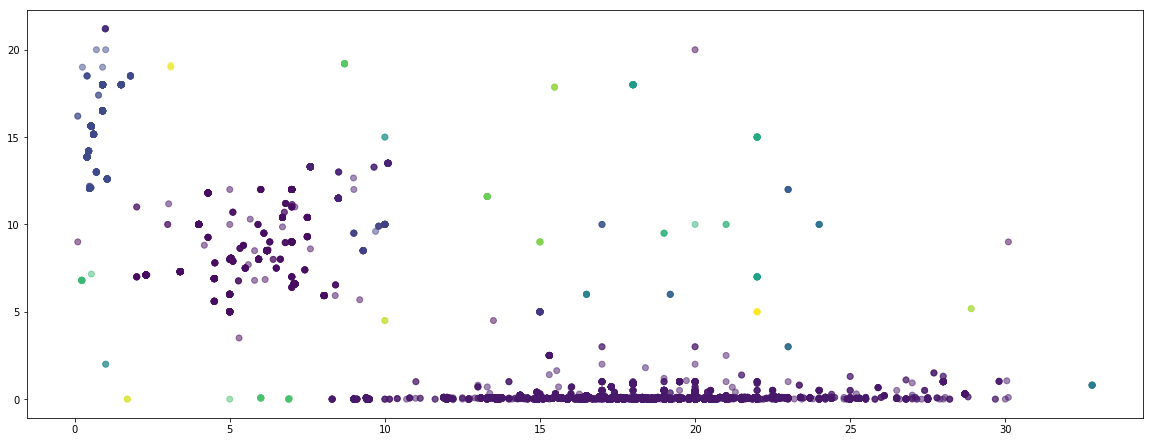

In [71]:
plt.figure(figsize = (20,7.5))
plt.scatter(df_cluster['thc_%'],df_cluster['cbd_%'], c = df_cluster['y_DBS'], alpha=0.5);


DBS 0.513480367621106


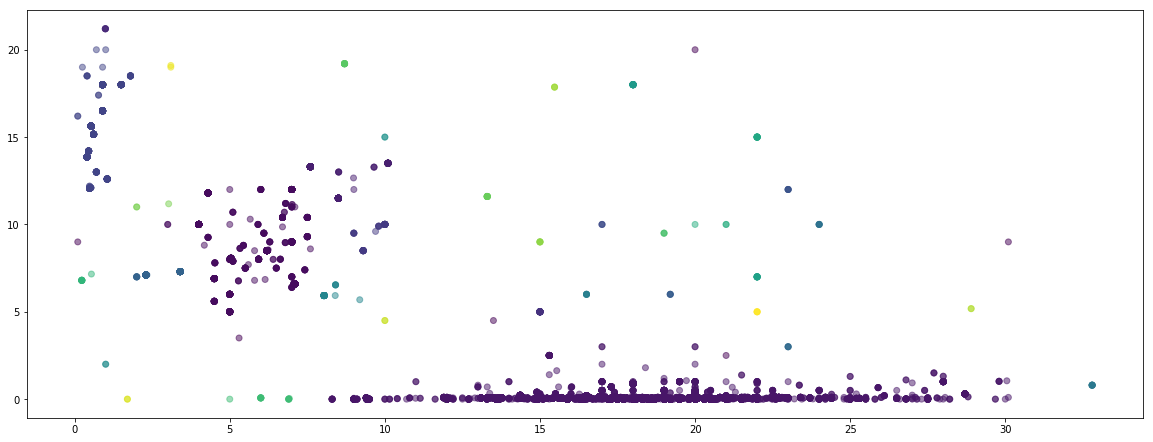

In [555]:
seed(76)
mask = (df['thc_%'] < 35) & (df['cbd_%'] < 25)
X_cluster = df[mask][['thc_%', 'cbd_%']]
df_cluster= X_cluster

model_DBS = DBSCAN(1.1,2).fit(X_cluster)
df_cluster['y_DBS'] = model_DBS.fit_predict(X_cluster)
score_sil = silhouette_score(df_cluster,model_DBS.labels_)
print('DBS', score_sil)
plt.figure(figsize = (20,7.5))
plt.scatter(df_cluster['thc_%'],df_cluster['cbd_%'], c = df_cluster['y_DBS'], alpha=0.5);

The following is the moment when one realizes that you can overfit a cluster model by accidentally having the following line of code:
    
    "df_cluster = X_cluster"
also this is when I learned that this would essentialy make the two objects the same under different sudonymes.

In [558]:
#df_dbs_results.to_csv('./data/sil_scores_3_53.csv',index = False)
df_dbs_results.sort_values('silhouette')

eps  min_samples  silhouette
45  1.1          2.0    0.513480
43  1.1          1.0    0.513952
44  1.1          1.0    0.513952
53  0.9          2.0    0.692219
36  0.9          2.0    0.692219
34  0.8          2.0    0.692219
32  0.7          2.0    0.692219
51  0.8          2.0    0.692219
30  0.6          2.0    0.692219
49  0.7          2.0    0.692219
47  0.6          2.0    0.692219
46  0.6          1.0    0.693214
35  0.9          1.0    0.693214
33  0.8          1.0    0.693214
31  0.7          1.0    0.693214
29  0.6          1.0    0.693214
52  0.9          1.0    0.693214
50  0.8          1.0    0.693214
48  0.7          1.0    0.693214
16  0.4          2.0    0.721892
18  0.5          2.0    0.721892
24  1.1          2.0    0.722464
20  0.7          2.0    0.722464
22  0.9          2.0    0.722464
17  0.5          1.0    0.723343
15  0.4          1.0    0.723343
23  1.1          1.0    0.723708
19  0.7          1.0    0.723708
21  0.9          1.0    0.723708
28  1.5          2.0    0.724471
27  1.5          1.0    0.725630
26  1.3          2.0    0.726202
25  1.3          1.0    0.727311
2   0.3          3.0    0.751158
8   0.7          3.0    0.752187
5   0.5          3.0    0.752279
11  0.9          3.0    0.753027
14  1.1          3.0    0.755444
1   0.3          2.0    0.757789
4   0.5          2.0    0.758865
7   0.7          2.0    0.759454
0   0.3          1.0    0.760114
10  0.9          2.0    0.760265
3   0.5          1.0    0.760729
13  1.1          2.0    0.760818
6   0.7          1.0    0.761099
9   0.9          1.0    0.761514
12  1.1          1.0    0.761758
55  0.1          2.0    0.962948
38  0.1          2.0    0.962948
54  0.1          1.0    0.967598
37  0.1          1.0    0.967598
42  1.2          2.0    0.968108
59  1.2          2.0    0.968108
58  1.2          1.0    0.969078
41  1.2          1.0    0.969078
40  1.1          2.0    0.971148
57  1.1          2.0    0.971148
39  1.1          1.0    0.972118
56  1.1          1.0    0.972118

 A better strategy might be implementing lines that would seperate the three clusters.  
 one for thc > cbd, 
 one for thc ~ cbd and 
 one for thc < cbd.
 
 Then, we take the dose and method as other axes to then guesstimate the amount of both chemicals that people are introducing into their systems.

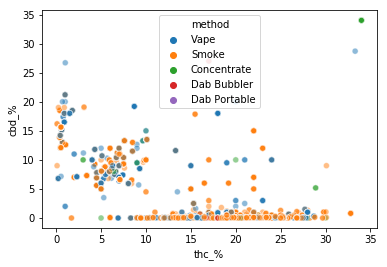

In [212]:
mask = (df['thc_%'] < 35) & (df['cbd_%'] < 35)
sns.scatterplot(df[mask]['thc_%'],df[mask]['cbd_%'], hue = df[mask]['method'], alpha=0.5);

In [458]:
df['method'].value_counts()

Smoke           5293
Vape            4343
Concentrate      349
Dab Bubbler       69
Dab Portable      11
Name: method, dtype: int64

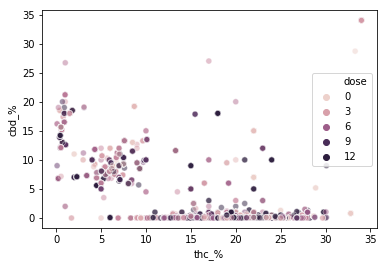

In [213]:
mask = (df['thc_%'] < 35) & (df['cbd_%'] < 35)
sns.scatterplot(df[mask]['thc_%'],df[mask]['cbd_%'], hue = df[mask]['dose'], alpha=0.5);

# Stacking/Feeding models to other models

In [7]:
# Creating the modeled Data Frame
X = df[['session', 'userid', 'gender', 'age', 'dose', 'time_lag', 'thc_%',
       'cbd_%', 'before', 'concentrate', 'smoke', 'vape', 'symptom_a', 'symptom_d']]
y = df['after']
X_train_modeled, X_test_modeled, y_train_modeled, y_test_modeled = train_test_split(X, y, random_state=42)

In [8]:
# Generating the Linear Regression Responces to the Data Frame
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=76)
model_lin = LinearRegression().fit(X_train, y_train)

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=77)
X_train_modeled['y_LinReg'] = model_lin.predict(X_train)
X_test_modeled['y_LinReg'] = model_lin.predict(X_test)

In [9]:
# K Neighbors
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
model_KNeighbors = KNeighborsRegressor().fit(X_train, y_train)

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=79)
X_train_modeled['y_KNeighbors'] = model_KNeighbors.predict(X_train)
X_test_modeled['y_KNeighbors'] = model_KNeighbors.predict(X_test)

In [10]:
# Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=80)
model_RForest = RandomForestRegressor().fit(X_train, y_train)

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=81)
X_train_modeled['y_RForest'] = model_RForest.predict(X_train)
X_test_modeled['y_RForest'] = model_RForest.predict(X_test)

In [11]:
# Gradient Boost
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=82)
model_Gradient = GradientBoostingRegressor().fit(X_train, y_train)

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=83)
X_train_modeled['y_Gradient'] = model_Gradient.predict(X_train)
X_test_modeled['y_Gradient'] = model_Gradient.predict(X_test)

In [12]:

#pd.concat()

session  userid  gender  age  dose  time_lag  thc_%  cbd_%  before  \
9092        2    3324       1   58    10      52.3  21.50   0.00       9   
6432       15    4247       0   25     3      21.9  15.88   0.00       5   
3933        5    1901       1   43     6      22.7  13.77   0.07       6   
2770       32     114       0   49     5       0.6  24.40   0.05       8   
1832        5    3419       0   32    10      21.1  18.50   0.00       6   
7129       43     399       1   36     6      64.8  21.50   0.00       8   
4254       43    2181       1   31     9      43.4  19.00   0.50       6   
9191       15    3485       1   24     3      37.4  19.00   0.00       5   
3375        1    1503       1   30     5      30.4  14.49   0.05       2   
4483       12    2586       1   40     4      35.1  14.36   0.22      10   
3698       48    1625       1   21     3       0.4  11.90   0.10       7   
9943        1    4866       1   32    10      22.2  20.00   0.00      10   
834         2    2199       1   26    10      20.4  19.50   0.00       4   
2486        6    4474       0   60    10      20.5   7.60  13.30       7   
6925        1    5197       0   27    10      37.2  19.00   0.00       5   
5090        1    3006       0   33    10       1.1  25.30   0.04       7   
7596        2    1507       1   35     5      48.0  18.10   0.00       4   
6424        7    4247       0   25     3      20.6  15.88   0.00       5   
6127       24    3929       0   32    10      23.2   0.61  15.16       6   
3538       82    1533       0   33    10      25.4  22.59   0.10       6   
65         67      97       1   46     3      20.5  15.88   0.00       8   
3061        1     925       1   56     6      21.9   6.76  10.70       5   
3795        6    1646       0   60     5      40.4  19.50   0.00       7   
3857        2    1714       1   54    10      22.5  16.40   0.00       5   
354         1    1506       1   55     4      21.5  22.00   0.00       7   
4076       11    1904       0   42     3      21.6  20.00   0.50       3   
4129       14    1978       0   40     1      30.1  25.90   0.66       8   
8740        3    2922       1   34     4      73.4  34.00  34.00       8   
3873        1    1758       1   30     5      28.8   0.61  15.16       6   
6842       12    4909       0   37     6      16.9  19.00   0.00       7   
...       ...     ...     ...  ...   ...       ...    ...    ...     ...   
8493        8    2564       0   45     7      22.0  20.50   0.00       4   
749         1    2128       0   45     2      20.9   8.51  13.00       5   
8685        2    2835       1   33     8     139.8  18.00   0.90       1   
2373        1    4260       0   19    10      22.0  18.50   0.00      10   
8047        4    1808       1   45    10      22.5   7.00   9.00       8   
4766       26    2723       1   25     2      73.5  15.90   0.07       9   
5620       55    3469       0   34    10      84.9  14.93   0.00       9   
6906       13    5074       1   32    10      40.7  20.00   0.00       5   
8426       10    2466       1   26     9      21.1  16.30   0.00       9   
7887       24    1689       0   27     5      20.8  20.40   0.40       4   
8035       44    1799       0   31    10      82.5  19.50   0.00       8   
3393        4    1511       0   30    10      20.6  17.70   0.00       2   
5379       24    3237       0   38    10      28.7  18.50   0.00       8   
4170        1    2128       0   45     1      21.5   8.51  13.00       4   
7365        1    1049       1   50     3      21.0  19.00   0.00       9   
4791       51    2723       1   25     2      20.9  17.70   0.07       5   
1139       18    2623       1   18    10      20.4  13.70   0.07      10   
7742        3    1566       1   45     3      20.9   5.44   8.80       4   
2231        6    3975       0   34    10      40.3  19.80   0.00       8   
2164       70    3929       0   32     6      59.7  24.00   0.50       3   
3059        1     905       0   24    10      20.6   5

In [15]:
X = pd.concat([X_train_modeled, X_test_modeled])
y = pd.concat([y_train_modeled, y_test_modeled])

model_NN = Sequential()
model_NN.add(Dense(18,
          activation = 'relu',
          input_dim=X.shape[1]))             # Shape Error?  Check on this.
model_NN.add(Dense(14, activation = 'relu'))
model_NN.add(Dense(10, activation = 'relu'))
model_NN.add(Dense(5, activation = 'relu'))
model_NN.add(Dense(1, activation=None))     
model_NN.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])

df_results = run_model(model_NN, X, y, df_results, is_neural_network= True,
                       NN_epochs = 50, 
                       NN_batch_size = 64,
                       NN_verbose = 0)

Neural Network Train
RMSE             : 2.5999655656323077
Median Abs Error : 1.0488380193710327
R Squared        : -0.4908357616583583

Neural Network Test
RMSE             : 2.6160314243308056
Median Abs Error : 1.0488380193710327
R Squared        : -0.46222311089061896


In [147]:
X_train_modeled.corrwith(y_train_modeled)[-4:]

y_LinReg       -0.019746
y_KNeighbors    0.006603
y_RForest      -0.002470
y_Gradient      0.028454
dtype: float64

This is the first time I've ever tried correlating the predictions to the actual answers and what an odd result I've obtained.
I suspect that this is why these numbers have actually worstened my neural network model.  In the future I believe that I'll need a better way of combining models that bettwe informs my main models of the best way to use the previous predictions.

## Gaussian Nieve Bayes, Revisited
After seeing that the predictions of all four models fall into a shape resembling a normal distribution, I decided to try Gaussian Nieve Bayes again while including those .

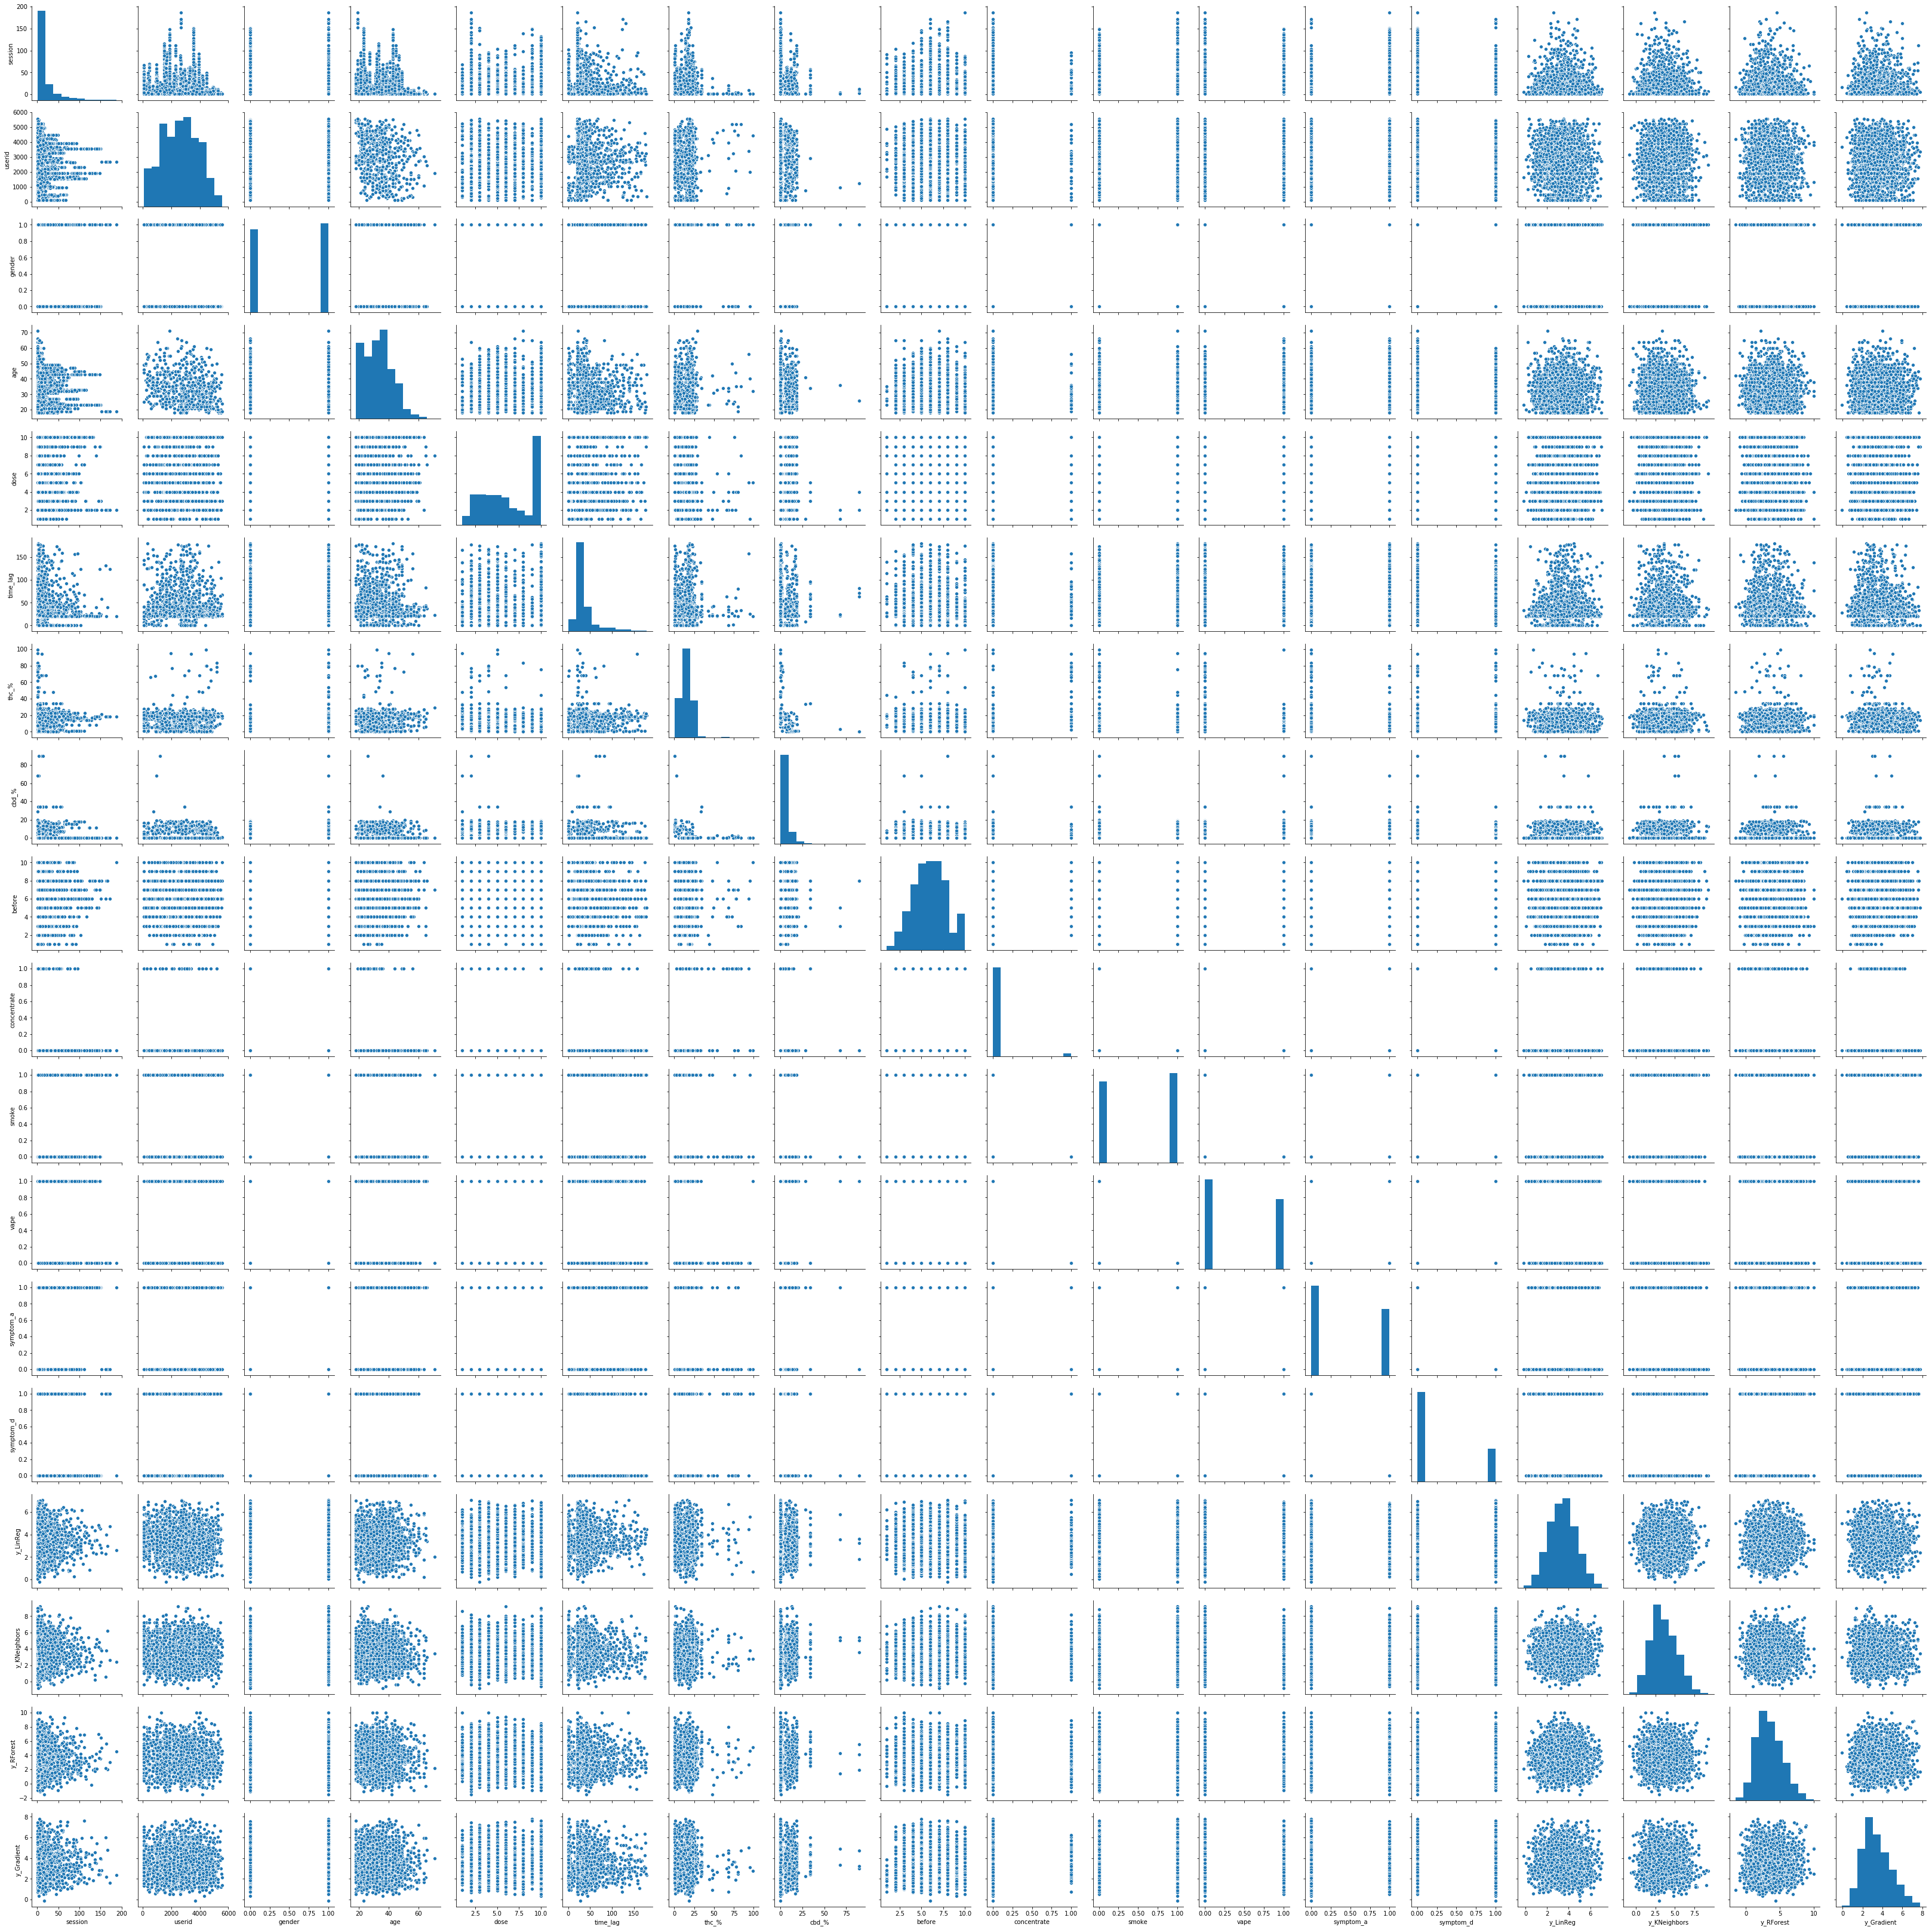

In [134]:
sns.pairplot(X_test_modeled);

In [144]:
X_g = pd.concat([X_train_modeled, X_test_modeled])[['userid', 'before', 'y_LinReg', 'y_KNeighbors', 'y_RForest', 'y_Gradient']]
y_g = pd.concat([y_train_modeled, y_test_modeled])
X_train, X_test, y_train, y_test = train_test_split(X_g, y_g, random_state=76)

model_gausNB = GaussianNB().fit(X_train, y_train)
Reg_metrics(y_train, model_gausNB.predict(X_train))
Reg_metrics(y_test, model_gausNB.predict(X_test))

RMSE            : 2.326464787449971
Median Abs Error: 1.0
R Squared       : -0.10749132103237025
RMSE            : 2.2708037169175967
Median Abs Error: 1.0
R Squared       : -0.08327784037104724


Welp.
On the otherhand were any of them actually correlated in the more traditional sense?

## Attempting a Recurrent Neural Network

In [97]:
data = [[(i+j)/100 for i in range(5)] for j in range(100)]
target = [(i+5) for i in range(100)]

In [98]:
data = np.array(data, dtype=float)
target = np.array(target, dtype=float)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=78)

In [ ]:
test_NN = Sequential()

test_NN.add(LSTM(1))
test_NN.add(Dense(1, activation=None)) 
test_NN.compile(loss='mean_squared_error', optimizer='adam')
history = test_NN.fit(X_train, y_train, 
                    epochs= 50,                               # Default is 1, but start with about 10
                    batch_size = 32,
                    verbose = 0,
                    validation_data = (X_test,y_test))

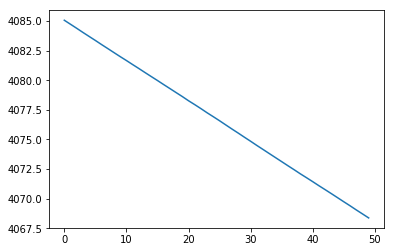

In [102]:
plt.plot(history.history['loss']);

In [599]:
model_NN = Sequential()

#model_NN.add(LSTM(18))

model_NN.add(Dense(18,
          activation = 'relu',
          input_dim=18))
model_NN.add(Dense(15, activation = 'relu')) # Here, have another layer
#model_NN.add(Dense(10, activation = 'relu')) # Here, have another layer
#model_NN.add(Dense(5, activation = 'relu')) # Here, have another layer
model_NN.add(Dense(1, activation=None))     
model_NN.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse])




df_results = run_model(model_NN, pd.concat([X_train_modeled, X_test_modeled]), 
                       y, df_results, is_neural_network= True,
                       NN_epochs = 50, 
                       NN_batch_size = 128,
                       NN_verbose = 0)
#results = model_NN.fit(X_train_modeled, y_train_modeled, 
#                    epochs= 50,                               # Default is 1, but start with about 10
#                    batch_size = 128,
#                    validation_data = (X_test_modeled,y_test_modeled))

Neural Network Train
RMSE             : 2.1852978310697164
Median Abs Error : 1.3999885320663452
R Squared        : -0.03354933124007431

Neural Network Test
RMSE             : 2.1527748303353578
Median Abs Error : 1.2984983921051025
R Squared        : -0.04810673667576393


# Visualizing a Decision Tree

In [ ]:
# REQUIREMENTS:
# pip install pydot2
# brew install graphviz

# Use graphviz to make a chart of the regression tree decision points:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()  

export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
# load dataset
data = load_wine()

# feature matrix
X = data.data

# target vector
y = data.target

# class labels
labels = data.feature_names

# print dataset description
print(data.DESCR)
estimator = DecisionTreeClassifier()
estimator.fit(X, y)

graph = Source(tree.export_graphviz(estimator, out_file=None
   , feature_names=labels, class_names=['0', '1', '2'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

list_of_series = []
for num in set(df['age'].unique()):
    mask = df['age'] == num
    list_of_series.append(df[mask]['method'].value_counts(normalize = True))

def Reg_CV_scores(model, X, y):
    cv = cross_validate(model_lin, X, y, return_train_score=True, scoring='neg_mean_squared_error')#.mean()
    print(np.sqrt(cv['test_score'].mean() * -1))
    np.scv['train_score'].mean()